# Second Hands Prices

This is a review of the AutoTrader data we have regarding second hand vehicle sales. The plots below aim to assist in our understanding of monthly trends in new registrations and the prices of vehicles over time.

Created for New AutoMotive by Corrin Reilly.

Notes:
- Vehicles from the 'Other' category are generally ignored.

## Imports

In [1]:
# Packages
import matplotlib.pyplot as plt
from mplcursors import cursor
import pandas as pd

# Modules
from modules.connector import MyBigQuery

## Initialise Connections

In [2]:
bq = MyBigQuery(
    credentials_file='./credentials/New AutoMotive Index-487e031dc242.json'
)

## Gather Data

In [3]:
df_sh = bq.from_bq_to_dataframe(
    query="""
    WITH earliest_dos AS (
        SELECT
            id,
            MIN(dos) AS earliest_dos
        FROM `rugged-baton-283921.second_hand.autotrader`
        GROUP BY
            id
    )

    SELECT
        FORMAT_DATE('%Y-%m', DATE(dos)) AS month,
        CASE
            WHEN t.fuelType IN ('Hydrogen', 'nan', 'Bi Fuel', 'None') THEN 'Other'
            WHEN t.fuelType IN ('Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid', 'Diesel Hybrid') THEN 'Hybrid'
            ELSE t.fuelType
        END AS ft,
        MIN(price) as min_price,
        MAX(price) as max_price,
        AVG(price) as avg_price,
        APPROX_QUANTILES(price, 2)[OFFSET(1)] AS median_price,
        COUNT(t.fuelType) AS registrations
    FROM `rugged-baton-283921.second_hand.autotrader` AS t
    JOIN earliest_dos AS ed ON t.id = ed.id AND t.dos = ed.earliest_dos
    GROUP BY
        month, ft
    ORDER BY
        month, ft ASC;
    """
)
df_sh.set_index('month', inplace=True)
df_sh.head()

,ft,min_price,max_price,avg_price,median_price,registrations
month,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15990.0,234488
2022-12,Electric,5995.0,179999.0,41034.287954,34985.0,12693
2022-12,Hybrid,2395.0,179995.0,32819.671634,27999.0,48446
2022-12,Other,1495.0,749995.0,23971.481203,12895.0,133
2022-12,Petrol,380.0,1000000.0,20107.689402,16200.0,272185


## Define Constants

In [4]:
# Define fuel type colours.
colors = {
    'Hybrid': 'blue',
    'Diesel': 'black',
    'Petrol': 'grey',
    'Electric': 'green'
}

## Prepare Data for Plotting

In [5]:
# Copy data to new DataFrame.
df_sh_prop = df_sh.copy()

totals = {}

# Calculate the total number of registrations for each month.
for date in df_sh_prop.index.unique():
    df_date = df_sh_prop[df_sh_prop.index == date].copy()
    total = df_date.registrations.sum()
    totals[date] = total

In [6]:
# Update DataFrame to have a column for the total registrations for that month.
for index, row in df_sh_prop.iterrows():
    if index in totals:
        df_sh_prop.loc[index, 'sum'] = totals[index]

df_sh_prop.head()

,ft,min_price,max_price,avg_price,median_price,registrations,sum
month,,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15990.0,234488,567945.0
2022-12,Electric,5995.0,179999.0,41034.287954,34985.0,12693,567945.0
2022-12,Hybrid,2395.0,179995.0,32819.671634,27999.0,48446,567945.0
2022-12,Other,1495.0,749995.0,23971.481203,12895.0,133,567945.0
2022-12,Petrol,380.0,1000000.0,20107.689402,16200.0,272185,567945.0


In [7]:
# Create a column that shows the proportion (%) of the months registrations that fuel type accounts for.
df_sh_prop['proportion'] = df_sh_prop.apply(lambda x: (100 * x['registrations']) / x['sum'] if x['sum'] != 0 else 0, axis=1)
df_sh_prop.head()

,ft,min_price,max_price,avg_price,median_price,registrations,sum,proportion
month,,,,,,,,
2022-12,Diesel,390.0,556950.0,20315.275673,15990.0,234488,567945.0,41.287096
2022-12,Electric,5995.0,179999.0,41034.287954,34985.0,12693,567945.0,2.234900
2022-12,Hybrid,2395.0,179995.0,32819.671634,27999.0,48446,567945.0,8.530051
2022-12,Other,1495.0,749995.0,23971.481203,12895.0,133,567945.0,0.023418
2022-12,Petrol,380.0,1000000.0,20107.689402,16200.0,272185,567945.0,47.924535


## Create Plots

### No. of New Registrations by Fuel Type and Month

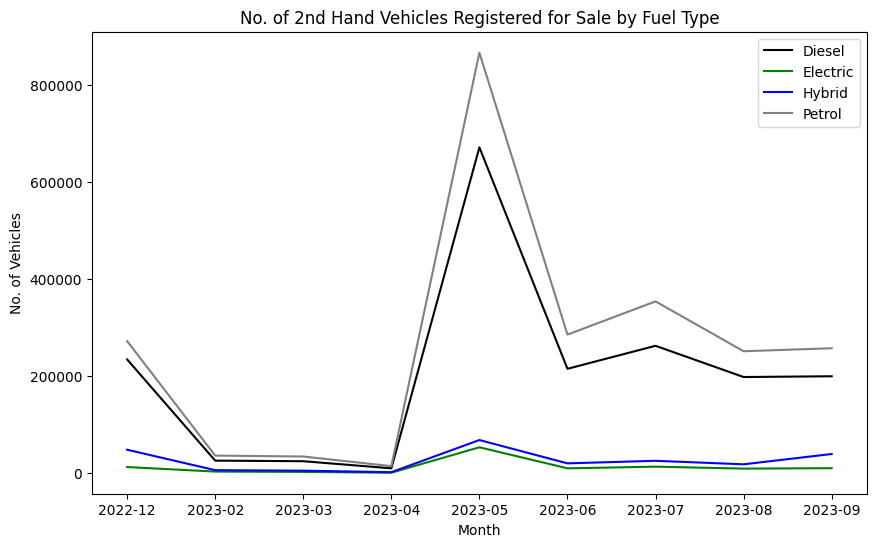

In [8]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh.ft.unique():
    if ft != 'Other':
        df_plot = df_sh.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.registrations, label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('No. of Vehicles')
ax.set_title('No. of 2nd Hand Vehicles Registered for Sale by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Monthly Difference in New Registrations.

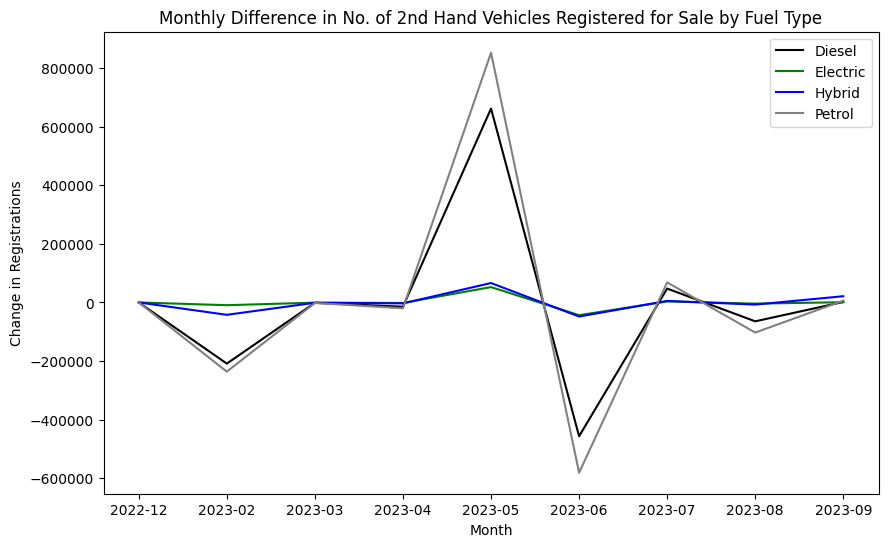

In [9]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh.ft.unique():
    if ft != 'Other':
        df_plot = df_sh.query(f'ft == "{ft}"').copy()
        df_plot['diff'] = df_plot['registrations'].diff()
        df_plot['diff'].fillna(0, inplace=True)
        ax.plot(df_plot.index, df_plot['diff'], label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Change in Registrations')
ax.set_title('Monthly Difference in No. of 2nd Hand Vehicles Registered for Sale by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Proportion of Each Fuel Type as New Registrations

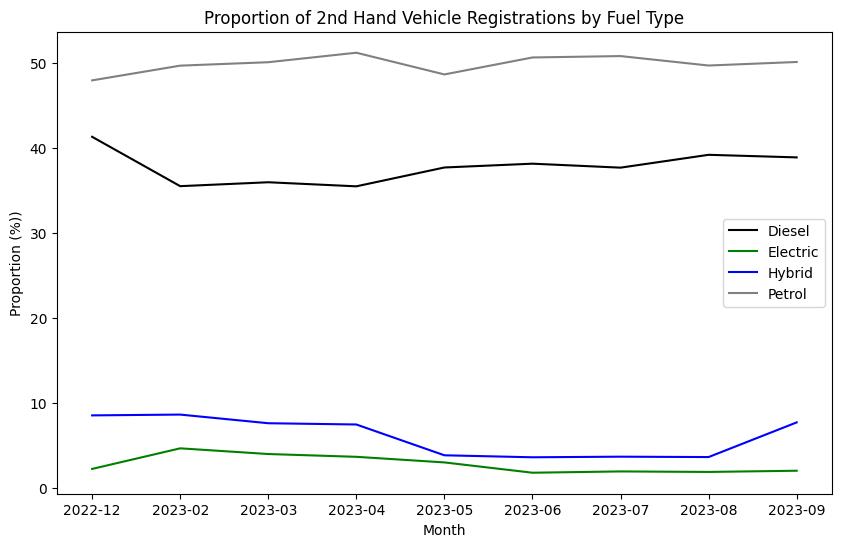

In [10]:
# Create the plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.proportion, label=ft, color=colors[ft])

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Proportion (%))')
ax.set_title('Proportion of 2nd Hand Vehicle Registrations by Fuel Type')

# Show legend.
ax.legend()

# Show the plot.
plt.show()

### Avg. Price of New Registrations by Fuel Type

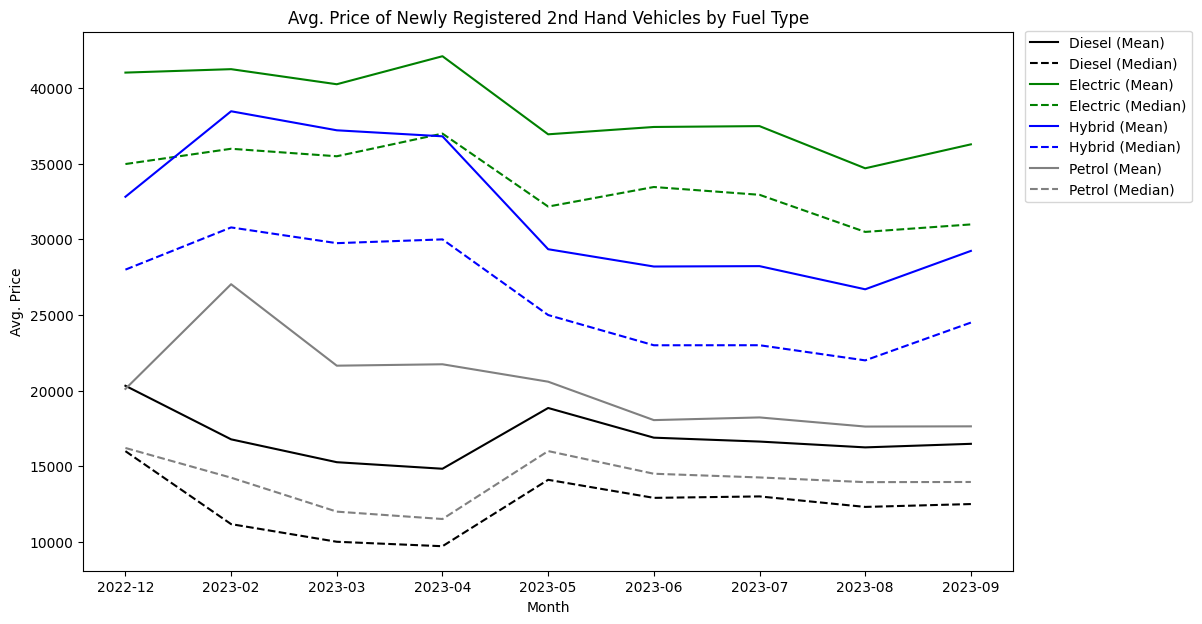

In [11]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.avg_price, label=ft + ' (Mean)', color=colors[ft])
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linestyle='dashed')

# Labels
ax.set_xlabel('Month')
ax.set_ylabel('Avg. Price')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend
ax.legend(bbox_to_anchor=(1.2, 1.015), loc='upper right')

plt.show()

### Plot of Median and Min. Prices of Fuel Types

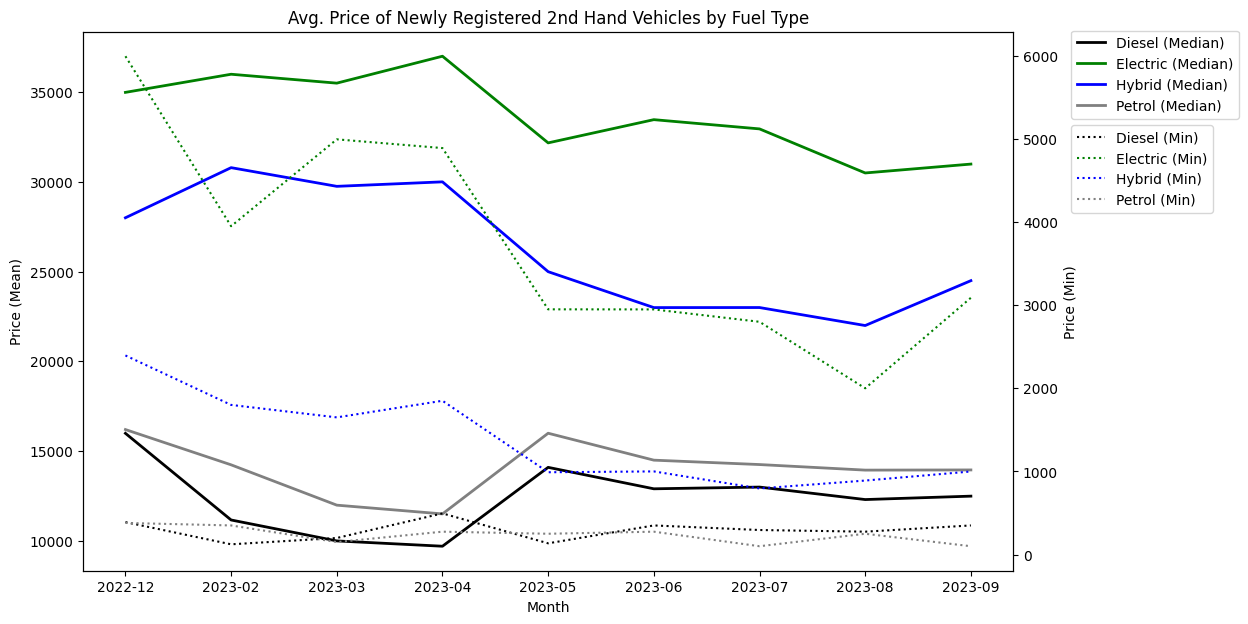

In [12]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

ax2 = ax.twinx()
ax2.set_ylabel('Price (Min)')

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linewidth=2)
        ax2.plot(df_plot.index, df_plot.min_price, label=ft + ' (Min)', color=colors[ft], linestyle=':')

# Labels
ax.set_xlabel('Month')
ax.set_ylabel('Price (Mean)')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend
ax.legend(bbox_to_anchor=(1.25, 1.015), loc='upper right')
ax2.legend(bbox_to_anchor=(1.222, 0.84), loc='upper right')

plt.show()

### Plot of Median and Max. Prices of Fuel Types

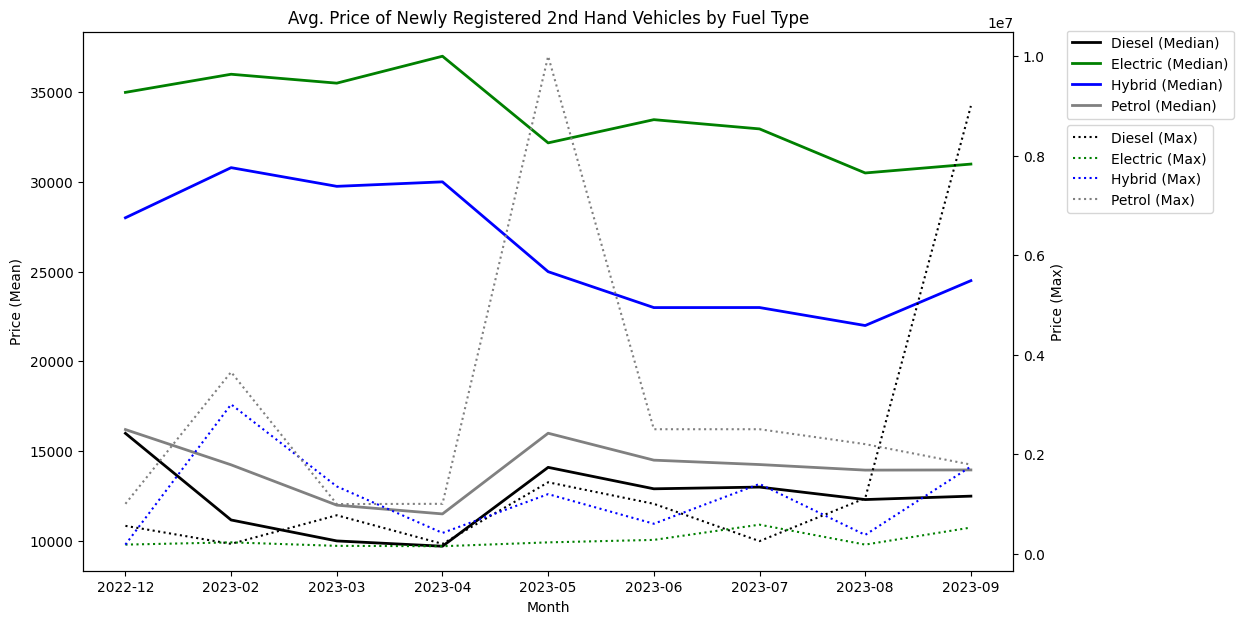

In [13]:
# Create the plot.
fig, ax = plt.subplots(figsize=(12, 7))

ax2 = ax.twinx()
ax2.set_ylabel('Price (Max)')

# Define plot for each fuel type.
for ft in df_sh_prop.ft.unique():
    if ft != 'Other':
        df_plot = df_sh_prop.query(f'ft == "{ft}"').copy()
        ax.plot(df_plot.index, df_plot.median_price, label=ft + ' (Median)', color=colors[ft], linewidth=2)
        ax2.plot(df_plot.index, df_plot.max_price, label=ft + ' (Max)', color=colors[ft], linestyle=':')

# Labels.
ax.set_xlabel('Month')
ax.set_ylabel('Price (Mean)')
ax.set_title('Avg. Price of Newly Registered 2nd Hand Vehicles by Fuel Type')

# Show legend.
ax.legend(bbox_to_anchor=(1.245, 1.015), loc='upper right')
ax2.legend(bbox_to_anchor=(1.222, 0.84), loc='upper right')

# Show the plot.
plt.show()